This notebook walks through the process of fitting cleaned TESS lightcurves with a model of contributions from the planet's atmospheric brightness modulation, stellar harmonics, and stellar pulsations.

**Prerequisite:** the data explored in this notebook must be lightcurves cleaned for phase curve analysis, i.e.
- Bad quality flag data have been removed
- Transits and secondary eclipses have been removed
- Data taken around momentum dumps have been removed
- Unexpected flux ramps have been removed
These clean lightcurves are produced in the TESSPhaseCurve_KELT-9b_DataCleaning.ipynb notebook.

# Background

There are many different methods of fitting a model to data. We will use ***Bayesian parameter estimation*** to fit our TESS lightcurves with our multi-component model. There are two concepts pertinent to this technique. First is the ***Bayesian approach*** which estimates parameter values by updating a prior belief about model parameters with new evidence.
1. The prior belief is represented by a ***prior distribution***, a probability distribution that describes the plausibility of the parameter having a range of values based on prior information. We will adopt either ***uniform*** or ***Gaussian*** priors as depicted below:
<div>
<img src="notebook_images/prior_distributions.png" width="1000"/>
</div> 
The x-axis represents a range of parameter values and the y-axis represents their corresponding probabilities. The uniform prior on the left assigns an equal probability to any value between $a$ and $b$. The Gaussian prior on the right assigns the highest probability to the value $\mu$.
2. The new evidence is called a ***likelihood distribution***. It attributes the probability of the parameter having a given value by comparing the resulting model to the data. The parameter value that yields the closest match to the data has the highest probability. This is quantified by the $\chi^2$ function:

    $\chi^2 = \sum_{i=1}^{N} \Big( \frac{O_i - E_i}{\sigma_i} \Big)^2$

    where $O_i$ is an observation (data point), $E_i$ is the expected value of that observation (model point), and $\sigma_i$ is the uncertainty on that observation (errorbar). The goal is to minimize $\chi^2$ because the closer the model matches the data, the smaller the difference will be and therfore $\chi^2$ will be smaller.
    
These two probabilities, the prior and the likelihood, are combined using Bayes's theorem to determine the ***posterior proability***, which is the overall probability assigned to a parameter value given the priors and the data. Bayes' Theorem says:

$p(\theta | S) = \frac{p(S | \theta) p(\theta)}{\int p(S | \theta) p(\theta)}$

Breaking it down into words, $p(\theta | S)$ is the probability of parameter value $\theta$ given a set of observations $S$, $p(S | \theta)$ is the likelihood probability, $p(\theta)$ the prior probability, and $\int p(S | \theta) p(\theta)$ is just the normalization needed so that the probabilities can be compared on the same scale and range from 0 to 1.

There are a lot of resources on Bayesian statistics on the internet. This video might help build your understanding: https://www.youtube.com/watch?v=HZGCoVF3YvM&ab_channel=3Blue1Brown.

The second concept relevant to Bayesian parameter estimation is ***parameter space sampling***. To find the best-fit parameters, we need some way of searching through different plausible values and applying Bayes' theorem to evaluate their posterior probabilities. We will do this using <a href="https://dynesty.readthedocs.io/en/latest/index.html">dynesty</a> to perform nested sampling. The technical details of nested sampling are not important for your research. The main point is that it performs a numerical integral of the posterior probability distribution over the prior volume (which set the bounds of the integral) from which you can recover posterior probabilities for all of the parameter values sampled. It does this by finding contours in parameter space of constant likelihood and honing in on the interior contours of higher likelihood (hence why it is called "nested" sampling); see <a href="https://www.youtube.com/watch?v=UnfjlA7EdjY&ab_channel=JuehangQin">this visualization</a>. Some more background on this is given here: https://dynesty.readthedocs.io/en/latest/overview.html

We will use <a href="https://dynesty.readthedocs.io/en/latest/index.html">dynesty</a> to search the parameter space to find the best-fit phase curve parameters and compute their associated uncertainties.

# Imports

You will need to have the following packages installed:
- numpy: https://numpy.org/install/
- matplotlib: https://matplotlib.org/stable/users/installing/index.html
- pandas: https://pandas.pydata.org/docs/getting_started/install.html
- astropy: https://docs.astropy.org/en/stable/install.html
- lightkurve: https://docs.lightkurve.org/about/install.html
- dynesty: https://dynesty.readthedocs.io/en/v1.2.3/

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd

# Exoplanet data packages
import lightkurve as lk

# Dynamic nested sampling
import dynesty
from dynesty import NestedSampler, DynamicNestedSampler
from dynesty import plotting as dyplot

# Library of custom functions
import TESSPhaseCurve_lib as TPC

# The following are my preferred matplotlib settings; I use a custom font that I have saved locally on my system.
# You can adjust the lines below to suit your preferences, or just comment them out entirely.
from matplotlib import font_manager
font_dir = ['/home/paiasnodkar.1/fonts'] # This will not work for you since it is a local directory on my system
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

fontweight = 300
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.monospace'] = ['Mulish']
plt.rcParams["font.weight"] = fontweight
plt.rcParams['axes.labelweight'] = 1.3*fontweight
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['axes.titlesize'] = 22

# Read in data

As before, let's use *pandas* to read in the data. Let's also store the data as a *Lightkurve* object to make it easier to phase-fold for plotting later.

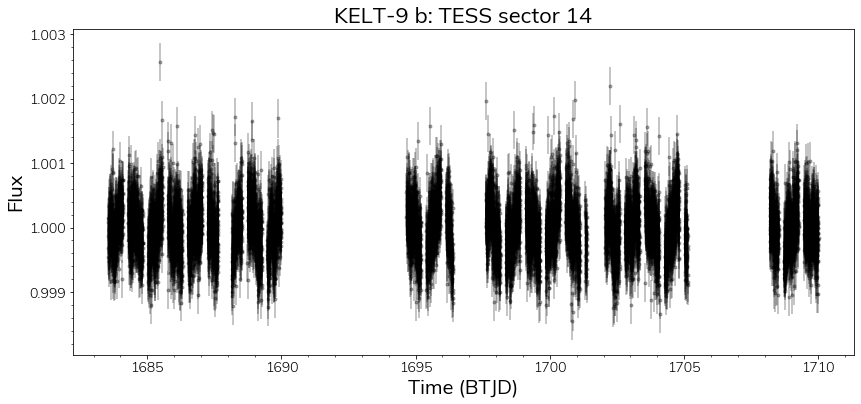

In [2]:
planet_name = 'KELT-9 b'
df = pd.read_csv('lightcurves/'+planet_name.replace(" ", "")+'.csv')
sectors = np.unique(df.sector)
sector_ind = 0 # set between 0 and len(sectors) to select an individual sector, set to 'all' for all sectors

if sector_ind == 'all':
    sector = 'all'
    time = np.array(df.time)
    flux = np.array(df.flux)
    flux_err = np.array(df.flux_err)
else:
    sector = sectors[sector_ind]
    sector_bool = df.sector == sector
    time = np.array(df.time)[sector_bool]
    flux = np.array(df.flux)[sector_bool]
    flux_err = np.array(df.flux_err)[sector_bool]        
    
lc_data = {'time': time,
           'flux': flux,
           'flux_err': flux_err
          }
lc_data = lk.LightCurve(lc_data)

# Plot lightcurve
plt.figure(figsize=(14,6))
plt.errorbar(time, flux, flux_err, fmt='.', color='k', alpha=0.3)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': TESS sector '+str(sector))
plt.show()

# Set up Bayesian framework

Here we will define our prior distributions for each of the model parameters. In total, we have 13 model parameters: $t_0$, $P$, $\Pi$, $\alpha$, $\beta$, $f_p$, $\delta$, $A_1$, $B_1$, $A_2$, $B_2$, $A_3$, and $B_3$

In [44]:
# Names of all the model parameters
labels = [r'$t_0$', r'$P$', r'$\Pi$', r'$\alpha$', r'$\beta$', r'$f_p$', r'$\delta$',
          r'$A_1$', r'$B_1$', r'$A_2$', r'$B_2$', r'$A_3$', r'$B_3$']
ndim = len(labels) # number of model parameters

# Define an array of booleans that describe whether the priors will be uniform (True) or Gaussian (False) in order for
# each parameter. We will adopt Gaussian priors for t_0, P, and Pi informed by the literature. We will adopt
# uninformed uniform priors for the remaining parameters.
priors_bool = np.array([True]*ndim)
priors_bool[0:2] = np.array([False]*2) # Setting the first two parameters to have Gaussian priors

# Define pairs of values that describe the priors for each parameter in order
priors = np.array([[2457095.68572-2457000.0, 0.00014], # t_0, Gaussian prior from Wong et al. 2020
                   [1.4811235, 0.0000011], # P, Gaussian prior from Wong et al. 2020
                   [(7.58695-3*0.00091)/24., (7.58695+3*0.00091)/24.], # Pi, uniform prior from Wong et al. 2020
                   [-1e-3, 1e-3], # alpha, uniform prior
                   [-1e-3, 1e-3], # beta, uniform prior
                   [0, 2e-3], # f_p, uniform prior
                   [-np.pi/3, np.pi/3], # delta, uniform prior
                   [-1e-3, 1e-3], # A_1, uniform prior
                   [-1e-3, 1e-3], # B_1, uniform prior
                   [-1e-3, 1e-3], # A_2, uniform prior
                   [-1e-3, 1e-3], # B_2, uniform prior
                   [-1e-3, 1e-3], # A_3, uniform prior
                   [-1e-3, 1e-3]]) # B_3, uniform prior

The *priors* and *priors_bool* will be used by the ***prior_transform*** function in our custom library *TESSPhaseCurve_lib.py*, which will get fed into our parameter space sampler. As part of the Bayesian framework, we will also compute the likelihood function using the ***loglike*** function in *TESSPhaseCurve_lib.py*; this function takes in the x values associated with the data (time), the observed data (flux), the associated errors (flux errors), and the model function we are trying to fit (*psi_tot_func* in *TESSPhaseCurve_lib.py*). We will need to aggregate these inputs for the prior and likelihood functions as shown below.

In [45]:
loglike_args = (lc_data.time.value, lc_data.flux.value, lc_data.flux_err.value, TPC.psi_tot_func) # loglike function arguments
ptform_args = (priors, priors_bool) # prior_transform function arguments

Now we can use *dynesty* to perform nested sampling, an advanced technique to search the parameter space for the best set of values that match the lightcurve model to the data.

In [46]:
# Initialize the sampler that will search the parameter space
sampler = DynamicNestedSampler(TPC.loglike, TPC.prior_transform, ndim,
                        logl_args=loglike_args, ptform_args=ptform_args)

# Run the sampler; we define convergence when the estimated contribution of the remaining prior volume to the
# total evidence falls below 1%
filename_root =''.join(planet_name.split())+'_sector'+str(sector) # filename at which to save progress
sampler.run_nested(dlogz_init=0.01, maxiter=100000, checkpoint_file=filename_root+'.save', print_progress=True)

# Save the results from running the sampler
res = sampler.results

# Extract the 50th percentile parameter samples as best fit parameters
params_best = np.array([dynesty.utils.quantile(res.samples[:, i], 0.50, 
                                              weights=res.importance_weights())[0] for i in range(ndim)])

28198it [28:23, 16.55it/s, batch: 4 | bound: 30 | nc: 1 | ncall: 857805 | eff(%):  3.227 | loglstar: 64835.549 < 64842.632 < 64840.457 | logz: 64803.482 +/-  0.209 | stop:  0.980]       


Let's plot the posterior distributions for each of the parameters in a corner plot. Ideally, the parameter distributions converge to unimodal distributions that appear roughly Gaussian.

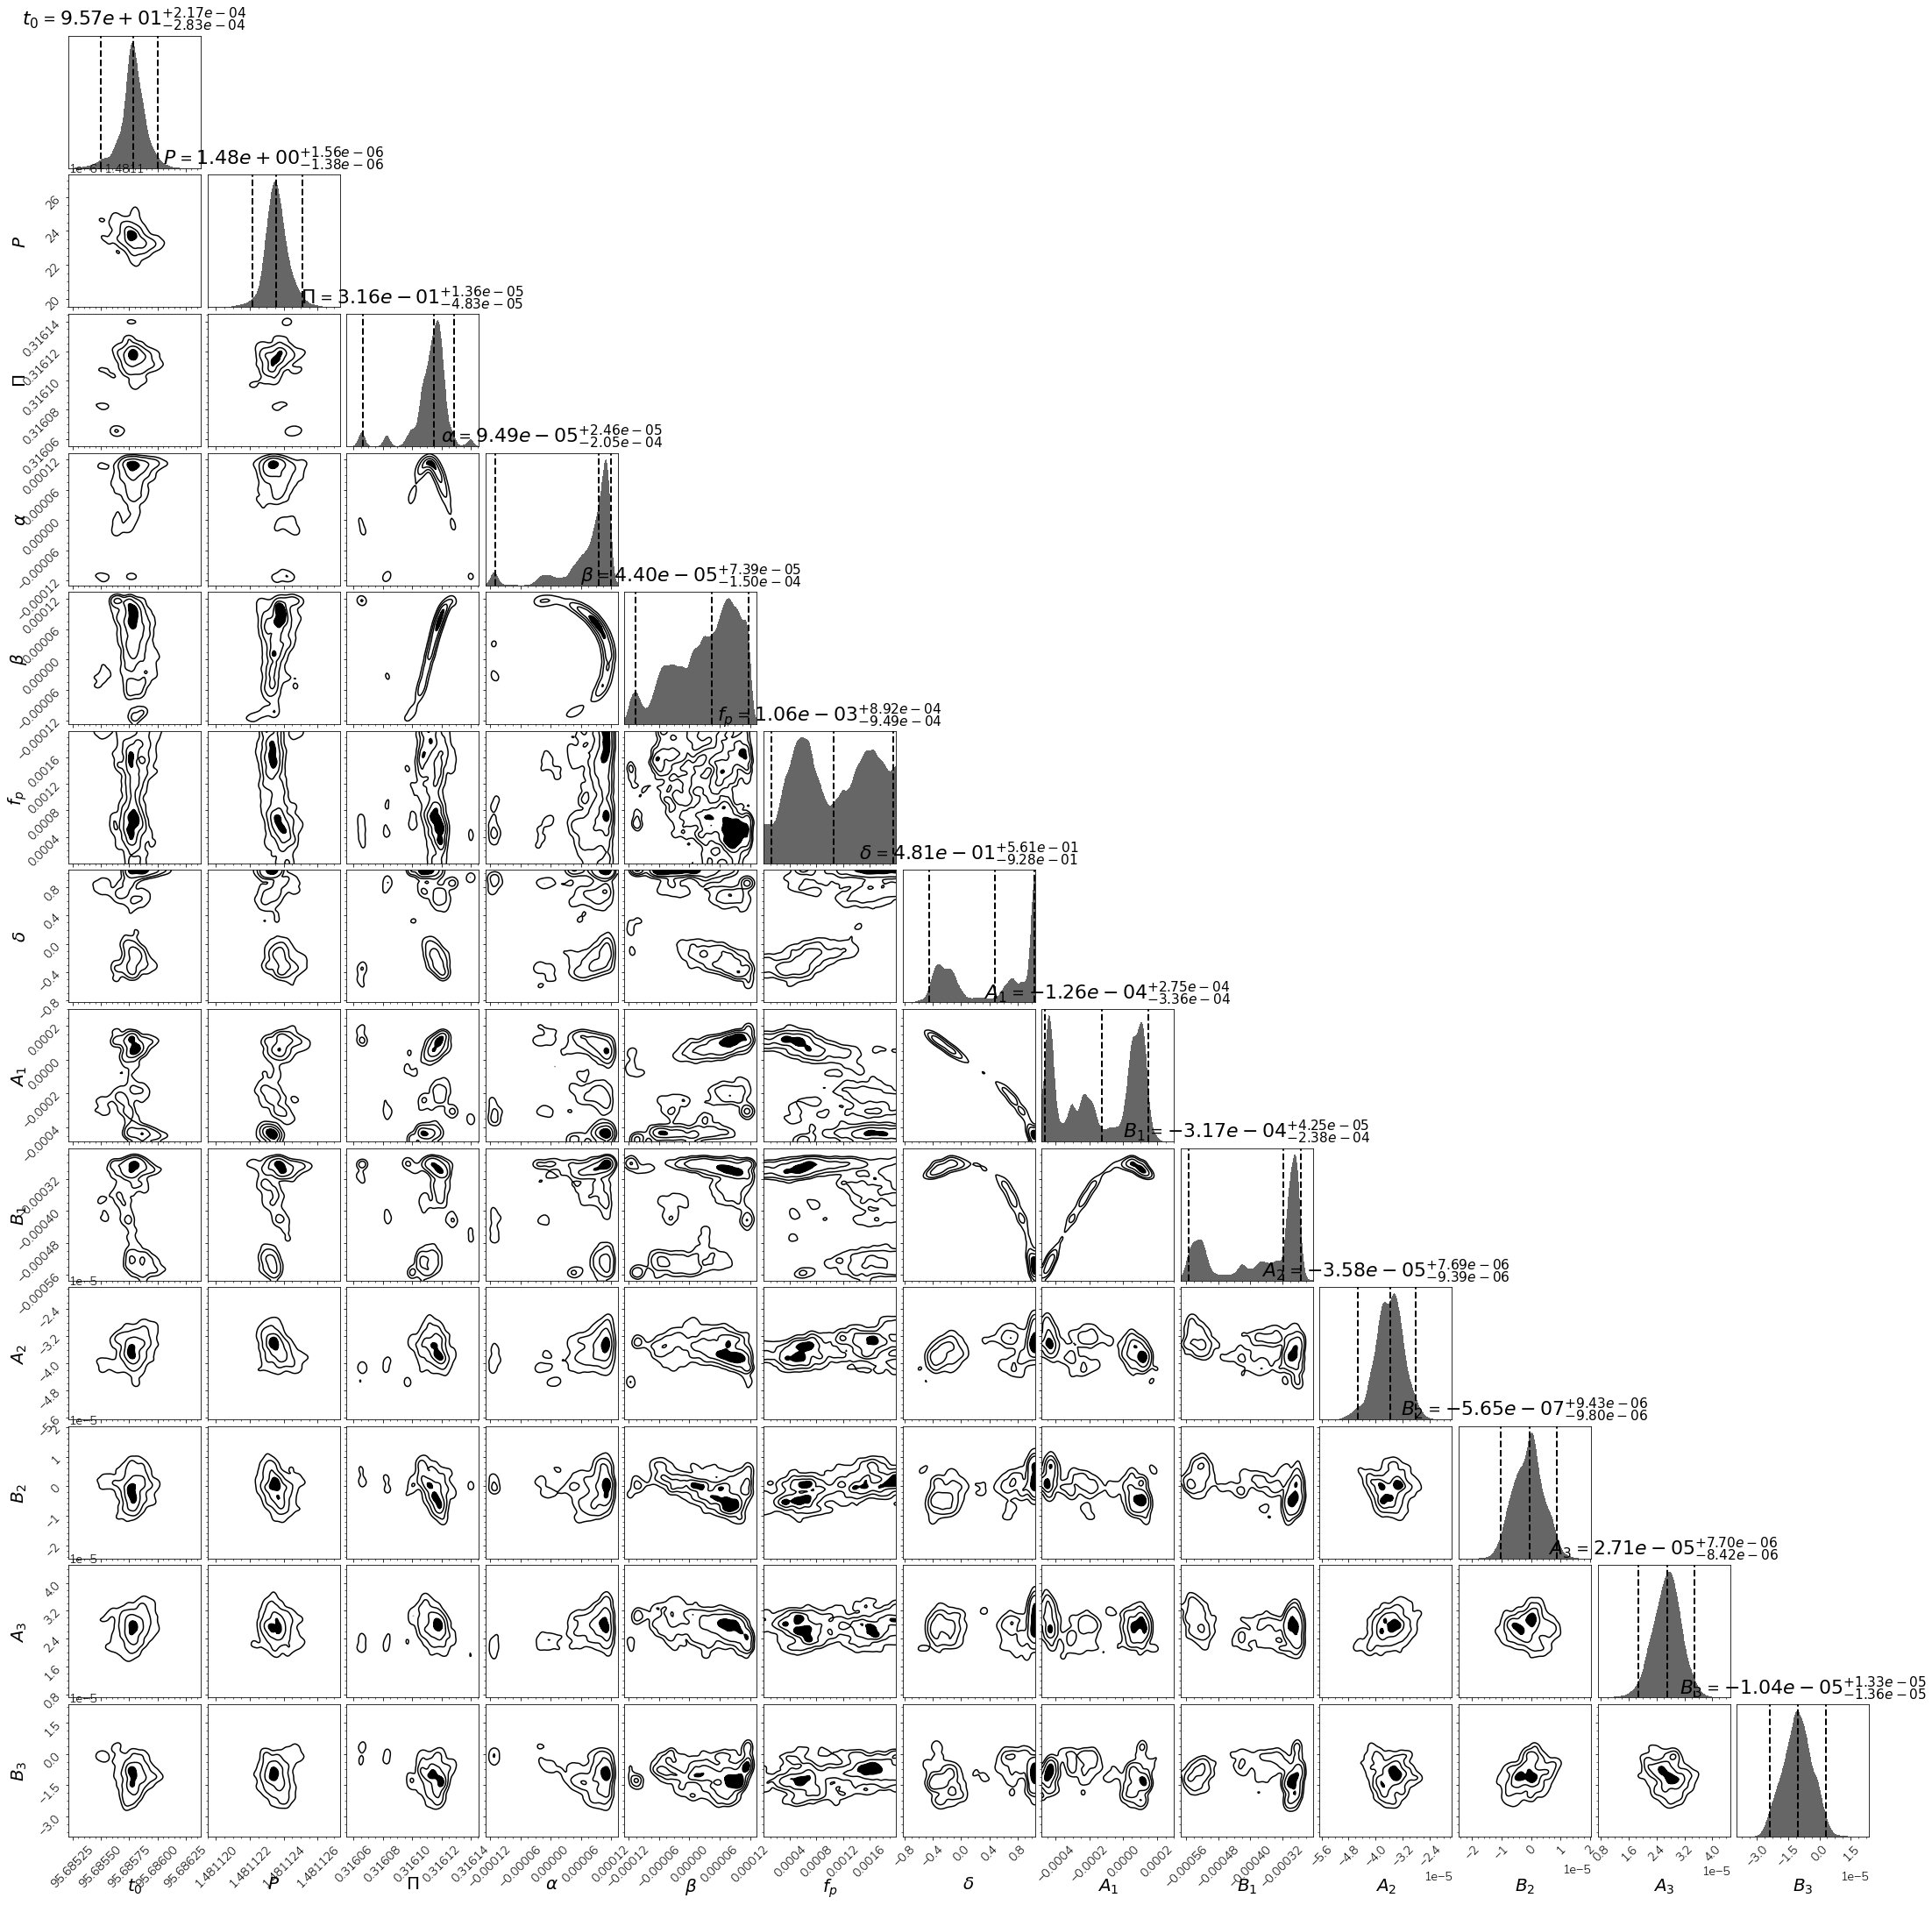

In [39]:
fig, axes = dyplot.cornerplot(res, show_titles=True, title_fmt='0.2e',
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(ndim, ndim, figsize=(30, 30)))

You can also include truths as a keyword argument in the cornerplot function above. The truths keyword argument takes in an array of values in order for each the parameters and will plot vertical/horizontal lines in each panel at the values you provided for each parameter. You can input the Wong et al. 2020 values to compare your fit to the reported values in the literature. See the *dynesty* documentation for more details on how to customize the cornerplot: https://dynesty.readthedocs.io/en/latest/api.html

Finally, let's compute the model lightcurve with our retrieved best-fit model parameters.

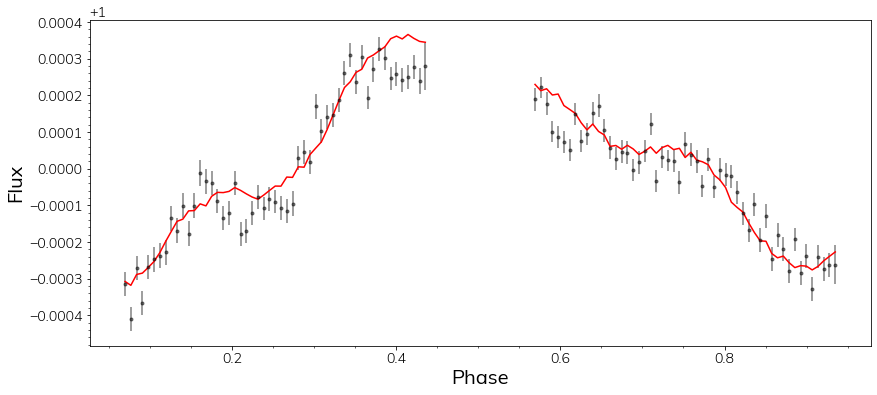

In [32]:
# Extract best-fit mid-transit time and planet orbital period
t_0_best, P_best = params_best[0]*u.day, params_best[1]*u.day

# Calculate model and assign to a Lightkurve object
model = TPC.psi_tot_func(params_best, lc_data.time.value)
lc_model = {'time': lc_data.time.value,
           'flux': model,
          }
lc_model = lk.LightCurve(lc_model)

# Phase fold and bin data and model
bin_width = (15*u.min).to(u.day)/P_best * u.day
lc_data_fold = TPC.fold_lk(lc_data, P_best, t_0_best)
lc_data_bin = lc_data_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)
lc_model_fold = TPC.fold_lk(lc_model, P_best, t_0_best)
lc_model_bin = lc_model_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)

# Plot data and best-fit model
plt.figure(figsize=(14,6))
plt.errorbar(lc_data_bin.time.value, lc_data_bin.flux.value, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.plot(lc_model_bin.time.value, lc_model_bin.flux.value, color='r')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.show()